In [19]:
import numpy as np
import gym
from collections import deque
import random
from scipy.ndimage.filters import uniform_filter1d
import torch.autograd
import os
import time
import imageio
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import sys
import morphsim as m
from graphenvs import HalfCheetahGraphEnv
import pickle
import matplotlib.pyplot as plt
import pybullet as p 
import pybullet 
import pybullet_envs.gym_pendulum_envs 
import pybullet_envs.gym_locomotion_envs
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
import time
import networkx as nx

%matplotlib widget

Running on the GPU


In [2]:
class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

In [3]:
class QValue(nn.Module):
    def __init__(
        self,
        input_size_state,
        input_size_action,
        hidden_sizes
    ):
        super(QValue, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size_action + input_size_state
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(self.input_size, hidden_sizes[0]))
        self.layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(hidden_sizes[len(hidden_sizes) - 1], 1))
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        
        for layer in self.layers:
            x = layer(x)
            
        return x
    
class Policy(nn.Module):
    def __init__(
        self,
        input_size_state,
        hidden_sizes,
        output_size
    ):
        super(Policy, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size_state
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(self.input_size, hidden_sizes[0]))
        self.layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(hidden_sizes[len(hidden_sizes) - 1], output_size))
        self.layers.append(nn.Tanh())
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [4]:
class DDPGagent:
    def __init__(self, env, q_hidden_sizes=[32, 64, 128, 64, 32], p_hidden_sizes=[32, 64, 128, 64, 32], actor_learning_rate=1e-3, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=int(1e6)):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Networks

        self.actor = Policy(self.num_states, p_hidden_sizes, self.num_actions).to(device)
        self.actor_target = Policy(self.num_states, p_hidden_sizes, self.num_actions).to(device)
        self.critic = QValue(self.num_states, self.num_actions, q_hidden_sizes).to(device)
        self.critic_target = QValue(self.num_states, self.num_actions, q_hidden_sizes).to(device)
        
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = Memory(max_memory_size)
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
        lmbda = lambda epoch: 0.8
        self.actor_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(self.actor_optimizer, lr_lambda=lmbda)
        self.critic_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(self.actor_optimizer, lr_lambda=lmbda)

    def get_action(self, state):
        state = torch.from_numpy(state).float().to(device)
        action = self.actor.forward(state)
        return action.cpu().detach().numpy()
    
    def get_latest_lr(self):
        return self.critic_lr_scheduler.get_last_lr()
    
    def update_lr(self):
        self.critic_lr_scheduler.step()
        self.actor_lr_scheduler.step()
    
    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.FloatTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
    
        # Critic loss        
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()
        
        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
            
    def save_agent_networks(self, prefix):
        torch.save(self.actor, prefix + '-actor.pt')
        torch.save(self.critic, prefix + '-critic.pt')
        
    def load_agent_networks(self, prefix):
        self.actor = torch.load(prefix + '-actor.pt').to(device)
        self.critic = torch.load(prefix + '-critic.pt').to(device)
        self.actor_target = self.actor
        self.critic_target = self.critic
        

In [5]:
env = HalfCheetahGraphEnv(None)
env.set_morphology(5)
state = env.reset()
print(state)

/home/ovi/anaconda3/envs/honors-project/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
NoneType: None


None
*************************************************************************************************************
[-6.35577677e-03  6.27771035e-04 -1.50858272e-03 -1.85047499e-01
  1.00000000e+00 -7.83421157e-04 -1.10498059e-03 -7.09529617e-04
  4.66362981e-05 -1.51040254e-03 -3.11328797e-04 -2.52985890e-04
  4.46977764e-02 -1.23729169e-01 -1.45899445e-01 -3.56372073e-02
 -1.27934754e-01 -2.11784877e-02 -3.30584161e-02]


In [ ]:
print(env._current_env._pb_env.robot.robot_body.pose().xyz())

[-0.08971457  0.          0.63248918]


In [7]:
try:
    env._current_env.close()
except:
    pass

env = HalfCheetahGraphEnv(None)
allAgents = dict()
allRewards = dict()
allAvgRewards = dict()
for idx in [5]:
    env.set_morphology(idx)
    state = env.reset()

    agent = DDPGagent(env, gamma=0.99, actor_learning_rate=1e-2, critic_learning_rate=1e-2)
    batch_size = 128
    rewards = []
    avg_rewards = []
    learningRates = []
    episodeLengths = []
    for episode in range(800):
        t0 = time.time()
        state = env.reset()
        episode_reward = 0
        step = 0
        done = False

        for i in range(1000):
            
            env._current_env._pb_env.camera_adjust()
            action = agent.get_action(state)
            
            # Only add noise in every second episode
            if episode % 2 == 0:
                action = np.clip(action + np.random.normal(0, 0.1, env.action_space.shape), -1, 1)
                
            new_state, reward, done, _ = env.step(action)
            agent.memory.push(state, action, reward, new_state, done)

            if len(agent.memory) > batch_size:
                agent.update(batch_size)

            state = new_state
            episode_reward += reward
            step += 1

            if done:
                break

        if episode % 50 == 0:
            agent.update_lr()

        print("episode {} in {}s: reward for episode: {} || average reward: {} || episode length: {}\n".format(episode, np.round(time.time() - t0, decimals=1), np.round(episode_reward, decimals=2), 
                                                                                                                  np.round(np.mean(rewards[-25:]), decimals=2), step))

        episodeLengths.append(step)
        rewards.append(episode_reward)
        avg_rewards.append(np.mean(rewards[-25:]))
        learningRates.append(agent.get_latest_lr())
    
#     allAgents[idx] = agent
#     allRewards[idx] = rewards
#     allAvgRewards[idx] = avg_rewards
    
    fig, ax = plt.subplots()
    ax.plot(range(len(rewards)), rewards)
    ax.plot(range(len(avg_rewards)), avg_rewards)
    ax.set(ylabel='Reward')
    ax.legend(["Episode", "Last 25 Avg"])
    plt.xlabel('Episode')
    plt.suptitle('Half-Cheetah {}'.format(idx))
    plt.show()
    fig.savefig('{}-new-halfCheetah-Training.jpg'.format(idx))
    
    agent.save_agent_networks('{}-new-halfCheetah'.format(idx))
    
    env._current_env.close()




NoneType: None
NoneType: None


None
*************************************************************************************************************
None
*************************************************************************************************************


KeyboardInterrupt: 

In [ ]:
env = HalfCheetahGraphEnv(None)
env.set_morphology(0)
g = env.get_graph()._get_dgl_graph()
nx_G = g.cpu().to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

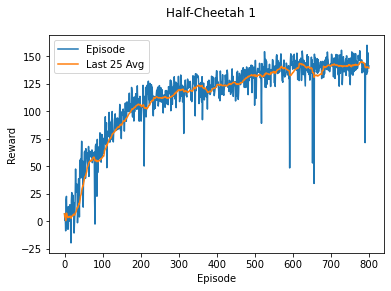

In [7]:
for idx in [1]:
    avg_rewards = allAvgRewards[idx]
    rewards = allRewards[idx]
    
    fig, ax = plt.subplots()
    ax.plot(range(len(rewards)), rewards)
    ax.plot(range(len(avg_rewards)), avg_rewards)
    ax.set(ylabel='Reward')
    ax.legend(["Episode", "Last 25 Avg"])
    plt.xlabel('Episode')
    plt.suptitle('Half-Cheetah {}'.format(idx))
    plt.show()
    fig.savefig('{}-new-halfCheetah-Training.jpg'.format(idx))

In [53]:
for idx in [4]:
    
    try:
        env._current_env.close()
    except:
        pass
    
    env = HalfCheetahGraphEnv(None)
    env.set_morphology(idx)
    
    agent = DDPGagent(env)
    agent.load_agent_networks('../old-run/{}-halfCheetah'.format(idx))
    
    episodeRewards = []
    states, actions, rewards, next_states, dones = [], [], [], [], []
    im_array, speeds = [], []
    collectedSamples = 0
    samplesToPrint = 10000
    episode = 0
    while collectedSamples < 1e6:
        episode += 1
        state = env.reset()

        step = 0
        episodeReward = 0
        for i in range(1000):
            
            env._current_env._pb_env.camera_adjust()
            im_array.append(env._current_env._pb_env.render_camera_image())
            action = agent.get_action(state)
            action = np.clip(action + np.random.normal(0, 0.25, env.action_space.shape), -1, 1)
                
            next_state, reward, done, _ = env.step(action)
            episodeReward += reward
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            
            speeds.append(state[0])
            
            state = next_state
            step += 1
            collectedSamples += 1
            samplesToPrint -= 1
        
        episodeRewards.append(episodeReward)
        
        if samplesToPrint <= 0:
            print(collectedSamples)
            print('Average Rewards', np.mean(episodeRewards[-1:]))
            samplesToPrint = 10000
            
        break
    np.save("../datasets-old-run//{}/actions_array".format(idx), np.array(actions))
    np.save("../datasets-old-run/{}/states_array".format(idx), np.array(states))
    np.save("../datasets-old-run/{}/next_states_array".format(idx), np.array(next_states))
    np.save("../datasets-old-run/{}/rewards_array".format(idx), np.array(rewards))
    np.save("../datasets-old-run/{}/dones_array".format(idx), np.array(dones))

NoneType: None
/home/ovi/anaconda3/envs/honors-project/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
NoneType: None


None
*************************************************************************************************************
None
*************************************************************************************************************


In [54]:
speeds = np.array(speeds)
im_array = (np.array(im_array) * 256).astype(np.uint8)
rewards = np.array(rewards)

In [69]:
fig, ax = plt.subplots(2, sharex=True)
ax[0].set_title('Speeds')
ax[1].set_title('Cumulative Rewards')
ax[0].plot(uniform_filter1d(speeds, size=10))
ax[1].plot(np.cumsum(rewards))
ax[1].set_xlabel('Steps')
ax[1].set_ylabel('Reward')
ax[1].set_ylabel('Speed')
fig.savefig('trained-agent-speeds.png')
video = imageio.get_writer('trained-agent.mp4', mode='I', fps=24, codec='libx264', bitrate='16M')
for img in im_array:
    video.append_data(img)
video.close()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (320, 200) to (320, 208) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [33]:
np.save("../datasets-old-run//{}/actions_array".format(idx), np.array(actions))
np.save("../datasets-old-run/{}/states_array".format(idx), np.array(states))
np.save("../datasets-old-run/{}/next_states_array".format(idx), np.array(next_states))
np.save("../datasets-old-run/{}/rewards_array".format(idx), np.array(rewards))
np.save("../datasets-old-run/{}/dones_array".format(idx), np.array(dones))

In [ ]:
actions_array = np.array(actions)
states_array = np.array(states)
next_states_array = np.array(next_states)
rewards_array = np.array(rewards)
dones_array = np.array(dones)

In [ ]:
np.save("doubleInvertedPendulumDataset/actions_array", actions_array)
np.save("doubleInvertedPendulumDataset/states_array", states_array)
np.save("doubleInvertedPendulumDataset/next_states_array", next_states_array)
np.save("doubleInvertedPendulumDataset/rewards_array", rewards_array)
np.save("doubleInvertedPendulumDataset/dones_array", dones_array)

In [22]:
rewards = np.load('../datasets/4/rewards_array.npy').reshape((1000, 1000))

In [30]:
rewards.sum(-1)

array([184.9556964 , 181.8523796 , 193.94408341, 183.44129337,
       180.64109176, 180.19431868, 195.05416098, 191.66075613,
       185.23178686, 184.83808625, 189.29054343, 187.26766719,
       172.66705911, 183.35678013, 191.58278757, 191.19228284,
       188.60357521, 179.35838471, 185.06772218, 180.38621829,
       198.65760625, 186.80150511, 186.49208369, 186.33933581,
       179.75608735, 189.31464979, 180.91363922, 187.0118959 ,
       182.96585696, 186.74660712, 174.89349945, 197.73106056,
       185.23813966, 187.38368109, 202.80282222, 186.39710432,
       194.81292199, 182.14079405, 188.37803969, 184.80948302,
       182.89129084, 185.54310638, 183.39655991, 181.38017131,
       186.82772071, 177.02382323, 181.4150698 , 191.67631171,
       189.39870314, 177.17671724, 190.19296676, 187.40461689,
       181.24970671, 181.92511812, 188.27552174, 172.58033548,
       195.6184433 , 184.56487202, 181.26803971, 188.24231399,
       186.09620526, 195.51260621, 183.98206852, 189.23